In [1]:
# Run this cell to import the packages you will need to unpack the dataset
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pickle
import os
import zipfile
import scipy.ndimage
import tensorflow as tf

import sys
import json
import codecs

## Data

In [70]:
## for empty csv file
import pandas as pd
import numpy as np
classes = ['juice', 'water', 'bean', 'banana', 'beef jerky', 'raw beef',
       'noodle', 'cereal', 'chip', 'granola bar', 'cookie', 'cupcake',
       'milk', 'muffin', 'soda', 'chip', 'egg', 'energy bar', 'pill',
       'breakfast food', 'condiment', 'cheeto', 'chocolate drink',
       'mac n cheese', 'mushroom', 'nut', 'pizza', 'pot pie', 'pretzel',
       'pudding', 'apple', 'salt', 'yogurt', 'sugar', 'tomatoe', 'soup',
       'tuna']
data = pd.read_csv("picture_classes.csv")


In [71]:
same = np.random.randint(2, size = data.shape[0])

In [72]:
from random import randint
vals = []
for i in range(data.shape[0]):
    if same[i] == 1:
        vals.append(data['class'][i])
    else:
        vals.append(classes[randint(0, len(classes)-1)])

In [76]:
##see if it contains the class
vals = pd.Series(vals)
#question = 'are these ' +vals + 's'
question = 'is this a ' + vals
answer = data['class'] == vals

data['question'] = question
data['answer'] = answer

In [77]:
data['answer'].value_counts()

True     2339
False    2321
Name: answer, dtype: int64

In [78]:
data.head()

,picture_id,class,question2,answer2,question,answer
0,000000000.jpg,juice,are these juices,True,is this a juice,True
1,000000001.jpg,juice,are these juices,True,is this a juice,True
2,000000002.jpg,juice,are these pills,False,is this a pill,False
3,000000003.jpg,juice,are these juices,True,is this a juice,True
4,000000004.jpg,juice,are these sodas,False,is this a soda,False


In [79]:
di = {False: 'no', True: 'yes'}
data = data.replace({"answer2": di, "answer":di})
data.head()

,picture_id,class,question2,answer2,question,answer
0,000000000.jpg,juice,are these juices,yes,is this a juice,yes
1,000000001.jpg,juice,are these juices,yes,is this a juice,yes
2,000000002.jpg,juice,are these pills,no,is this a pill,no
3,000000003.jpg,juice,are these juices,yes,is this a juice,yes
4,000000004.jpg,juice,are these sodas,no,is this a soda,no


In [ ]:
### getting all the pickle files and combining them into one training list
train_imgs = []

with open('imgs_0_1000.p', "rb") as input_file:
    train_imgs = pickle.load(input_file)

train_imgs2 = []
with open('imgs_1000_2000.p', "rb") as input_file:
    train_imgs2 = pickle.load(input_file)

train_imgs3 = []
with open('imgs_2000_3000.p', "rb") as input_file:
    train_imgs3 = pickle.load(input_file)

train_imgs4 = []
with open('imgs_3000_4000.p', "rb") as input_file:
    train_imgs4 = pickle.load(input_file)

train_imgs5 = []
with open('imgs_4000_remaining.p', "rb") as input_file:
    train_imgs5 = pickle.load(input_file)

In [10]:
all_train_imgs = train_imgs + train_imgs2 + train_imgs3 + train_imgs4 + train_imgs5

all_qs = data['question2']

all_imgs = np.asarray(all_train_imgs)

In [52]:
# converting the questions into one hot encode

ID, ans_class = pd.factorize(data['answer2'])
one_hot_labels = tf.keras.utils.to_categorical(ID)
ans_class

Index(['no', 'yes'], dtype='object')

## Starting the Model

### First Converting the Questions into Bag of Words

In [11]:
### first question embedding just using BoWs
from sklearn.feature_extraction.text import CountVectorizer
BoW = CountVectorizer()

trans_all_qs = BoW.fit_transform(all_qs).toarray()
trans_all_qs.shape

(4660, 54)

### Splitting the questions and images into their respective training, validation, and test

In [16]:
### split the questions and images into training, validation, testing
arr = np.arange(all_imgs.shape[0])
np.random.shuffle(arr)
test_ind = arr[0:arr.shape[0]//5]
val_ind = arr[arr.shape[0]//5: 9* arr.shape[0]//25]
train_ind = arr[9*arr.shape[0]//25:]

train_qs = trans_all_qs[train_ind]
val_qs = trans_all_qs[val_ind]
test_qs = trans_all_qs[test_ind]

train_ims = all_imgs[train_ind]
val_ims = all_imgs[val_ind]
test_imgs = all_imgs[test_ind]

train_ans = one_hot_labels[train_ind]
val_ans = one_hot_labels[val_ind]
test_ans = one_hot_labels[test_ind]

In [17]:
train_ans.shape

(2983, 2)

### Creating the Model

In [1]:
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
from keras import layers
from keras import optimizers

#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
#inception_model = inception_v3.InceptionV3(weights='imagenet')
# Freeze the layers except the last 4 layers
for layer in vgg_model.layers[:-4]:
    layer.trainable = False
## Check the trainable status of the individual layers
for layer in vgg_model.layers:
    print(layer, layer.trainable)

# Add on to IMAGE model to merge
img_layer1 = layers.Flatten()(vgg_model.output)
img_layer2 = layers.Dense(1024, activation='relu')(img_layer1)
img_layer3 = layers.Dropout(0.5)(img_layer2)
img_layer4 = layers.Dense(len(classes), activation='relu')(img_layer3)

# Add on to QUESTION model to merge
q_layer1 = layers.Input((train_qs.shape[1],))
q_layer2 = layers.Dense(len(classes), activation = 'relu')(q_layer1)

# Add layers to help merge the image and question
merged = layers.add([img_layer4, q_layer2])
fc_1 = layers.Dense(100, activation = 'relu')(merged)
output = layers.Dense(2, activation = 'softmax')(fc_1)
model = models.Model([vgg_model.input, q_layer1], output)
# Add layers to output
#model.add(layers.Dense())
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Using TensorFlow backend.


<keras.engine.input_layer.InputLayer object at 0x7f120c575f60> False
<keras.layers.convolutional.Conv2D object at 0x7f11d8443978> False
<keras.layers.convolutional.Conv2D object at 0x7f11d83ed128> False
<keras.layers.pooling.MaxPooling2D object at 0x7f11d83edb38> False
<keras.layers.convolutional.Conv2D object at 0x7f11d841dd68> False
<keras.layers.convolutional.Conv2D object at 0x7f11d7bb2710> False
<keras.layers.pooling.MaxPooling2D object at 0x7f11d7bc6668> False
<keras.layers.convolutional.Conv2D object at 0x7f11d7b574e0> False
<keras.layers.convolutional.Conv2D object at 0x7f11d7b6fdd8> False
<keras.layers.convolutional.Conv2D object at 0x7f11d7b80cf8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f11d7b25710> False
<keras.layers.convolutional.Conv2D object at 0x7f11d7b36588> False
<keras.layers.convolutional.Conv2D object at 0x7f11d7b4cf60> False
<keras.layers.convolutional.Conv2D object at 0x7f11d7af2780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f11d7b07470>

NameError: name 'classes' is not defined

## Training the Model

In [30]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
model.fit([train_ims, train_qs], train_ans, epochs=3, batch_size=30)

Epoch 1/3
2983/2983 [==============================] - 687s 230ms/step - loss: 0.2798 - acc: 0.8921
Epoch 2/3
2983/2983 [==============================] - 2921s 979ms/step - loss: 0.2203 - acc: 0.9195
Epoch 3/3
2983/2983 [==============================] - 5475s 2s/step - loss: 0.1912 - acc: 0.9299


In [31]:
## Saving the model
# serialize model to JSON
model_json = model.to_json()
with open("model_VQA_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_VQA_5.h5")
print("Saved model to disk")

Saved model to disk


## Evaluation

In [27]:
### load the model if saved

from keras.models import model_from_json
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
from keras import layers
from keras import optimizers

json_file = open("model_VQA_4.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("model_VQA_4.h5")
print("Loaded model from disk")

Loaded model from disk


### Will use the test as validation

In [32]:
# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#loaded_model.summary()
score = model.evaluate([test_imgs, test_qs], test_ans, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 52.79%


## One Picture and One Question Output

[array(['are', 'breakfast', 'foods', 'these'], dtype='<U11')]
Class: yes 			Pecentage 99.04308915138245%
[1. 0.]
[array(['are', 'breakfast', 'foods', 'these'], dtype='<U11')]
Class: no 			Pecentage 0.9569097310304642%
[1. 0.]


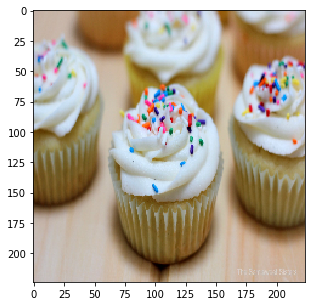

In [69]:
import random

fig=plt.figure(figsize=(5, 5))

columns = 1
rows = 1

fig.add_subplot(rows, columns, 1)

img_arr = val_ims

index = int(random.random()*img_arr.shape[0])

orig_img = img_arr[index]

one_image = np.expand_dims(orig_img, axis=0)

plt.imshow(orig_img)

orig_q = val_qs[index]
one_q = np.expand_dims(orig_q, axis = 0)


# returns an array with percentage posssibility of each class
perc_arr = model.predict([one_image, one_q])[0]

# returns an array with indices indictating from highest to lowest percentage
perc_ind = np.array(-perc_arr).argsort()


for i in range(2):
    class_val = ans_class[perc_ind[i]]
    
    perc_str = '\t\tPecentage'
    if(len(class_val)<9):
        perc_str = '\t' +perc_str
    print(BoW.inverse_transform(orig_q))
    print('Class:', class_val, perc_str, str(100 * perc_arr[perc_ind[i]])+'%')
    print(val_ans[index])